In [111]:
# python 2
try:
    from urllib.request import Request, urlopen  
# Python 3
except ImportError:
    from urllib2 import Request, urlopen

import pandas as pd
import time
import datetime
import numpy as np
import re
import json
from bs4 import BeautifulSoup
from pytrends.request import TrendReq

class Cryptory():
    
    def __init__(self, from_date, to_date=None, ascending=False, 
                 fillgaps=True, timeout=10.0):
        """Initialise cryptory class
        
        Parameters
        ----------
        from_date : the starting date (as string) for the returned data;
            required format is %Y-%m-%d (e.g. "2017-06-21")
        to_date : the end date (as string) for the returned data;
            required format is %Y-%m-%d (e.g. "2017-06-21")
            Optional. If unspecified, it will default to the current day
        to_date : binary. Determines whether the returned dataframes are
            ordered by date in ascending or descending order 
            (defaults to False i.e. most recent first)
        fillgaps : binary. When data does not exist (e.g. weekends for stocks)
            should the rows be filled in with the previous available data
            (defaults to True e.g. Saturday stock price will be same as Friday)
        fillgaps : float. The max time allowed (in seconds) to pull data from a website
            If exceeded, an timeout error is returned. Default is 10 seconds.
        """
        
        self.from_date = from_date
        # if to_date provided, defaults to current date
        if to_date is None:
            self.to_date = datetime.date.today().strftime("%Y-%m-%d")
        else:
            self.to_date = to_date
        self.ascending = ascending
        self.fillgaps = fillgaps
        self.timeout = timeout
        self._df = pd.DataFrame({'date':pd.date_range(start=self.from_date, end=self.to_date)})
        
    def extract_reddit_metrics(self, subreddit, metric, col_label="", sub_col=False):
        """Retrieve daily subscriber data for a specific subreddit scraped from redditmetrics.com
        
        Parameters
        ----------
        subreddit : the name of subreddit (e.g. "python", "learnpython")
        metric : the particular subscriber information to be retrieved
            (options are limited to "subscriber-growth" (daily change), 
            'total-subscribers' (total subscribers on a given day) and 
            'rankData' (the position of the subreddit on reddit overall)
            'subscriber-growth-perc' (daily percentage change in subscribers))
        col_label : specify the title of the value column
            (it will default to the metric name with hyphens replacing underscores)
        sub_col : whether to include the subreddit name as a column
            (default is False i.e. the column is not included)
            
        Returns
        -------
        pandas Dataframe
        """
        if metric not in ['subscriber-growth', 'total-subscribers', 'rankData', 'subscriber-growth-perc']:
            raise ValueError(
                "Invalid metric: must be one of 'subscriber-growth', " + 
                "'total-subscribers', 'subscriber-growth-perc', 'rankData'")
        url = "http://redditmetrics.com/r/" + subreddit
        if metric == 'subscriber-growth-perc':
            metric_name = 'total-subscribers'
        else:
            metric_name = metric
        try: 
            parsed_page = urlopen(url, timeout=self.timeout).read()
            parsed_page = parsed_page.decode("utf8")
        except:
            # future versions may split out the different exceptions (e.g. timeout)
            raise
        if metric == 'rankData':
            start_segment = parsed_page.find(metric)
        else:
            start_segment = parsed_page.find("element: '"+metric_name+"'")
        if start_segment != -1:
            start_list = parsed_page.find("[", start_segment)
            end_list = parsed_page.find("]", start_list)
            parsed_page = parsed_page[start_list:end_list + 1]
        else:
            return ValueError("Could not find that subreddit")
        parsed_page = parsed_page.replace("'", '"')
        parsed_page = parsed_page.replace('a', '\"subscriber_count\"')
        parsed_page = parsed_page.replace('y', '\"date\"')
        output = json.loads(parsed_page)
        output = pd.DataFrame(output)
        output['date'] = pd.to_datetime(output['date'], format="%Y-%m-%d")
        if metric == 'subscriber-growth-perc':
            output['subscriber_count'] = output['subscriber_count'].pct_change()
        output = output[(output['date']>=self.from_date) & (output['date']<=self.to_date)]
        output = output.sort_values(by='date', ascending=self.ascending).reset_index(drop=True)
        if sub_col:
            output['subreddit'] = subreddit
        if col_label != "":
            output = output.rename(columns={'subscriber_count': label})
        else:
            output = output.rename(columns={'subscriber_count': metric.replace("-","_")})
        return output
        
    def extract_coinmarketcap(self, coin, coin_col=False):
        """Retrieve basic historical information for a specific cryptocurrency from coinmarketcap.com
        
        Parameters
        ----------
        coin : the name of the cryptocurrency (e.g. 'bitcoin', 'ethereum', 'dentacoin')
        coin_col : whether to include the coin name as a column
            (default is False i.e. the column is not included)
            
        Returns
        -------
        pandas Dataframe
        """
        try:
            output = pd.read_html("https://coinmarketcap.com/currencies/{}/historical-data/?start={}&end={}".format(
                coin, self.from_date.replace("-", ""), self.to_date.replace("-", "")))[0]
        except:
            # future versions may split out the different exceptions (e.g. timeout)
            raise
        output = output.assign(Date=pd.to_datetime(output['Date']))
        for col in output.columns:
            if output[col].dtype == np.dtype('O'):
                output.loc[output[col]=="-",col]=0
                output[col] = output[col].astype('int64')
        output.columns = [re.sub(r"[^a-z]", "", col.lower()) for col in output.columns]
        if coin_col:
            output['coin'] = coin
        return output
    
    
    def get_google_trends(self, kw_list, trdays=250, overlap=100, 
                          cat=0, geo='', tz=360, gprop='', hl='en-US',
                          sleeptime=1, isPartial_col=False, 
                          from_start=False, scale_cols=True):
        
        """
            From pytrends github
        """
        
        
        if len(kw_list)>5 or len(kw_list)==0:
            raise ValueError("The keyword list can contain at most 5 words")
        if trdays>270:
            raise ValueError("trdays must not exceed 270")
        if overlap>=trdays:
            raise ValueError("Overlap can't exceed search days")
        stich_overlap = trdays - overlap
        from_date = datetime.datetime.strptime(self.from_date, '%Y-%m-%d')
        to_date = datetime.datetime.strptime(self.to_date, '%Y-%m-%d')
        n_days = (to_date - from_date).days
        # launch pytrends request
        _pytrends = TrendReq(hl=hl, tz=tz)
        # get the dates for each search
        if n_days <= trdays:
            trend_dates = [' '.join([self.from_date, self.to_date])]
        else:
            trend_dates = ['{} {}'.format(
            (to_date - datetime.timedelta(i+trdays)).strftime("%Y-%m-%d"),
            (to_date - datetime.timedelta(i)).strftime("%Y-%m-%d")) 
                           for i in range(0,n_days-trdays+stich_overlap,
                                          stich_overlap)]
        if from_start:
            trend_dates = trend_dates[::-1]
        try:
            _pytrends.build_payload(kw_list, cat=cat, timeframe=trend_dates[0], 
                                   geo=geo, gprop=gprop)
        except:
            raise
        output = _pytrends.interest_over_time().reset_index()
        if len(output)==0:
            raise ValueError('search term returned no results (insufficient data)')
        for date in trend_dates[1:]:
            time.sleep(sleeptime)
            try:
                _pytrends.build_payload(kw_list, cat=cat, timeframe=date, 
                                         geo=geo, gprop=gprop)
            except:
                raise
            temp_trend = _pytrends.interest_over_time().reset_index()
            temp_trend = temp_trend.merge(output, on="date", how="left")
            # it's ugly but we'll exploit the common column names
            # and then rename the underscore containing column names
            for kw in kw_list:
                norm_factor = np.ma.masked_invalid(temp_trend[kw+'_y']/temp_trend[kw+'_x']).mean()
                temp_trend[kw] = temp_trend[kw+'_x'] * norm_factor
            temp_trend =  temp_trend[temp_trend.isnull().any(axis=1)]
            temp_trend['isPartial'] = temp_trend['isPartial_x']
            output = pd.concat([output, temp_trend[['date', 'isPartial'] + kw_list]], axis=0, sort=False)
        
        # reorder columns in alphabetical order
        output = output[['date', 'isPartial']+kw_list]
        
        if not isPartial_col:
            output = output.drop('isPartial', axis=1)
        output = output[output['date']>=self.from_date]
        if scale_cols:
            # the values in each column are relative to other columns
            # so we need to get the maximum value across the search columns
            max_val = float(output[kw_list].values.max())
            for col in kw_list:
                output[col] = 100.0*output[col]/max_val
        output = output.sort_values('date', ascending=self.ascending).reset_index(drop=True)
        return output
    
    
    def extract_bitinfocharts(self, coin, metric="price", coin_col=False, metric_col=False):
        """Retrieve historical data for a specific cyrptocurrency scraped from bitinfocharts.com
        
        Parameters
        ----------
        coin : the code of the cryptocurrency (e.g. 'btc' for bitcoin)
            full range of available coins can be found on bitinfocharts.com
        metric : the particular coin information to be retrieved
            (options are limited to those listed on bitinfocharts.com
            including 'price', 'marketcap', 'transactions' and 'sentinusd'
        coin_col : whether to include the coin name as a column
            (default is False i.e. the column is not included)
        metric_col : whether to include the metric name as a column
            (default is False i.e. the column is not included)
            
        Returns
        -------
        pandas Dataframe
        """
        if coin not in ['btc', 'eth', 'xrp', 'bch', 'ltc', 'dash', 'xmr', 'btg', 'etc', 'zec', 
                        'doge', 'rdd', 'vtc', 'ppc', 'ftc', 'nmc', 'blk', 'aur', 'nvc', 'qrk', 'nec']:
            raise ValueError("Not a valid coin")
        if metric not in ['transactions', 'size', 'sentbyaddress', 'difficulty', 'hashrate', 'price', 
                          'mining_profitability', 'sentinusd', 'transactionfees', 'median_transaction_fee', 
                        'confirmationtime', 'marketcap', 'transactionvalue', 'mediantransactionvalue',
                         'tweets', 'activeaddresses', 'top100cap']:
            raise ValueError("Not a valid bitinfocharts metric")
        new_col_name = "_".join([coin, metric])
        parsed_page = Request("https://bitinfocharts.com/comparison/{}-{}.html".format(metric, coin),
                            headers = {'User-Agent': 'Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/537.11 (KHTML, like Gecko) Chrome/23.0.1271.64 Safari/537.11'})
        try: 
            parsed_page = urlopen(parsed_page, timeout=self.timeout).read()
            parsed_page = parsed_page.decode("utf8")
        except:
            # future versions may split out the different exceptions (e.g. timeout)
            raise
        start_segment = parsed_page.find("new Dygraph")
        if start_segment != -1:
            start_list = parsed_page.find('[[', start_segment)
            end_list = parsed_page.find(']]', start_list)
            parsed_page = parsed_page[start_list:end_list]
        else:
            raise ValueError("Could not find the appropriate text tag in the scraped page")
        parsed_page = parsed_page.replace('new Date(', '')
        parsed_page = parsed_page.replace(')', '')
        parsed_page = parsed_page.replace('null', '0')
        parsed_page = parsed_page.replace('["', '{"date":"')
        parsed_page = parsed_page.replace('",', '","{}":'.format(new_col_name))
        parsed_page = parsed_page.replace('],', '},')
        parsed_page = parsed_page + '}]'
        output = json.loads(parsed_page)
        output = pd.DataFrame(output)
        output['date'] = pd.to_datetime(output['date'], format="%Y-%m-%d")
        output = output[(output['date']>=self.from_date) & (output['date']<=self.to_date)]
        # for consistency, put date column first
        output = output[['date', new_col_name]]
        if coin_col:
            output['coin'] = coin
        if metric_col:
            output['metric'] = metric
        return output.sort_values(by='date', ascending=self.ascending).reset_index(drop=True)
    
    def extract_poloniex(self, coin1, coin2, coin1_col=False, coin2_col=False):
        """Retrieve the historical price of one coin relative to another (currency pair) from poloniex
        
        Parameters
        ----------
        coin1 : the code of the denomination cryptocurrency 
            (e.g. 'btc' for prices in bitcoin)
        coin2 : the code for the coin for which prices are retrieved
            (e.g. 'eth' for ethereum)
        coin1_col : whether to include the coin1 code as a column
            (default is False i.e. the column is not included)
        coin2_col : whether to include the coin2 code as a column
            (default is False i.e. the column is not included)
            
        Returns
        -------
        pandas Dataframe
        """
            
        from_date = int(time.mktime(time.strptime(self.from_date, "%Y-%m-%d")))
        to_date = int(time.mktime(time.strptime(self.to_date, "%Y-%m-%d")))
        url = "https://poloniex.com/public?command=returnChartData&currencyPair={}_{}&start={}&end={}&period=86400".format(
                coin1.upper(), coin2.upper(), from_date, to_date)
        try: 
            parsed_page = urlopen(url, timeout=self.timeout).read()
            parsed_page = parsed_page.decode("utf8")
        except:
            # future versions may split out the different exceptions (e.g. timeout)
            raise
        output = json.loads(parsed_page)
        if isinstance(output, dict):
            if 'error' in list(output.keys()):
                raise ValueError("The content of the page was not as it should be")
        output = pd.DataFrame(output)
        # more intuitive column order
        output = output[['date', 'close', 'open', 'high', 'low', 
                        'weightedAverage', 'quoteVolume', 'volume']]
        output['date'] = pd.to_datetime(output['date'], unit='s')
        output = output.sort_values(by='date', ascending=self.ascending).reset_index(drop=True)
        if coin1_col:
            output['coin1'] = coin1
        if coin2_col:
            output['coin2'] = coin2
        return output



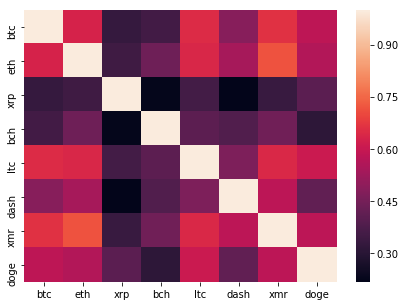

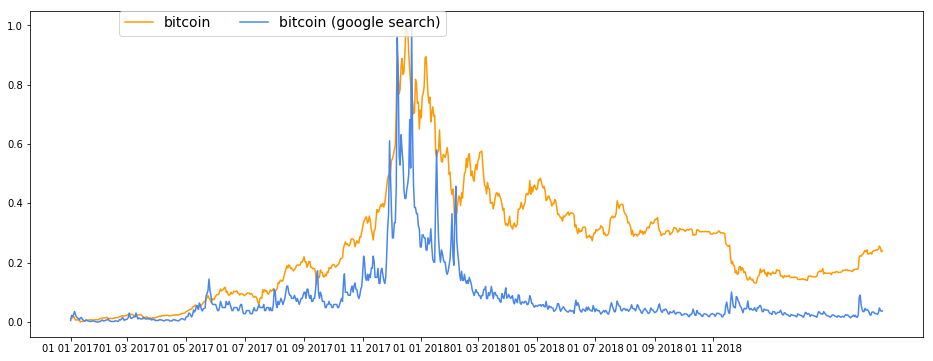

In [114]:
# pull data from start of 2017 to present day
my_cryptory = Cryptory(from_date = "2017-01-01")

######## Basic Usage

# get historical bitcoin prices from coinmarketcap
my_cryptory.extract_coinmarketcap("bitcoin")

# get daily subscriber numbers to the bitcoin reddit page
#my_cryptory.extract_reddit_metrics(subreddit="bitcoin",metric="total-subscribers")

# google trends- bitcoin search results
my_cryptory.get_google_trends(kw_list=["bitcoin"])


# generate price correlation matrix
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

all_coins_df = my_cryptory.extract_bitinfocharts("btc")
# coins of interest
bitinfocoins = ["btc", "eth", "xrp", "bch", "ltc", "dash", "xmr", "doge"]
for coin in bitinfocoins[1:]:
    all_coins_df = all_coins_df.merge(my_cryptory.extract_bitinfocharts(coin), on="date", how="left")

# date column not need for upcoming calculations
all_coins_df = all_coins_df.drop('date', axis=1)
corr = all_coins_df.pct_change().corr(method='pearson')
fig, ax = plt.subplots(figsize=(7,5))  
sns.heatmap(corr,xticklabels=[col.replace("_price", "") for col in corr.columns.values],yticklabels=[col.replace("_price", "") for col in corr.columns.values],annot_kws={"size": 16})
plt.show()


# overlay bitcoin price and google searches for bitcoin
btc_google = my_cryptory.get_google_trends(kw_list=['bitcoin']).merge( my_cryptory.extract_coinmarketcap('bitcoin')[['date','close']],on='date', how='inner')

# need to scale columns (min-max scaling)
btc_google[['bitcoin','close']] = (btc_google[['bitcoin', 'close']]-btc_google[['bitcoin', 'close']].min())/(btc_google[['bitcoin', 'close']].max()-btc_google[['bitcoin', 'close']].min())

fig, ax1 = plt.subplots(1, 1, figsize=(16, 6))

ax1.set_xticks([datetime.date(j,i,1) for i in range(1,13,2) for j in range(2017,2019)])

ax1.set_xticklabels([datetime.date(j,i,1).strftime('%d %m %Y') for i in range(1,13,2) for j in range(2017,2019)])

dates=np.array([btc_google['date'].dt.date])
dates=dates.T
dates=np.squeeze(dates)

ax1.plot(dates,btc_google['close'], label='bitcoin', color='#FF9900')

ax1.plot(dates,btc_google['bitcoin'], label="bitcoin (google search)", color='#4885ed')

ax1.legend(bbox_to_anchor=(0.1, 1), loc=2, borderaxespad=0., ncol=2, prop={'size': 14})

plt.show()